In [99]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
#allows to print the dataframe nicely
from IPython.core import display as ICD
#!pip install plotly
import plotly.plotly as py
from plotly.graph_objs import *
import plotly.tools as tls

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [100]:
# import additional packages to insepct data and clean them
import pandas as pd
import os 
import random 
from zipfile import ZipFile
import datetime

In [101]:
# import helping functions from the implementation file
#from proj1_helpers import load_csv_data
from proj1_helpers import *
from implementations import *
import seaborn as sns

# Code Outline

### Data Inspection and preparation 
In the first section the features provided were cleaned and studied; then, on the base of the scientific knowledge behind the Boson data and on the base of the features data, a method to select features was prepared. 

### Feature Generation
Before actually applying regression algorithms different feature spaces were generated; in this manner the performance results obtained with the different features could be compared in the testing phase and an evaluation of the most important features could be done.

### Testing
Hence the performance of a selection of regression models was compared with different features in order to obtain the best combination according to the prediction results obtained in the Kaggle competition

## Data Inspection and Preparation

In [102]:
# import zipped files from the github repository
data_folder='./data/'
zip_file = ZipFile(data_folder+'all.zip')
# zip file creates a list of files with certain properties
zip_file.infolist()

[<ZipInfo filename='train.csv' compress_type=deflate file_size=48103379 compress_size=17670847>,
 <ZipInfo filename='test.csv' compress_type=deflate file_size=109335584 compress_size=40089137>,
 <ZipInfo filename='sample-submission.csv' compress_type=deflate file_size=5682394 compress_size=1263762>]

Loading the training set and the testing set and creating dataframes to inspect the data.

In [103]:
# now we want to access the 'filename' property in the zipfile variable
# and we create a dictionary of dataframe
dfs = {text_file.filename: pd.read_csv(zip_file.open(text_file.filename))
       for text_file in zip_file.infolist()
       if text_file.filename.endswith('.csv')}
df_train=dfs['train.csv']
df_test=dfs['test.csv']
df_sample_submission=dfs['sample-submission.csv']

The first step was understanding the data structure and learning about the features we have been provided with. By studying the scientific backgroun about the experiment in the [competition description](https://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf), the relationship between the features was understood. 

In [104]:
df_train.head()

,Id,Prediction,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,100000,s,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,...,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497
1,100001,b,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,...,-1.916,164.546,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226
2,100002,b,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,...,-2.186,260.414,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251
3,100003,b,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,...,0.060,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000
4,100004,b,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,...,-0.871,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000


The first step was to do a preliminary study of the physical meaning and relationship between the features....

The first steps was taking care of the fact that certain datapoints could sometime take values not in the range of normal values. This happeneded when a data point had a value of -999.0.

In [105]:
# example of the part of the dataset where a column would get a value not in the normal range of values
df_train[df_train['DER_lep_eta_centrality']==-999.0].head()

,Id,Prediction,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
1,100001,b,160.937,68.768,103.235,48.146,-999.0,-999.0,-999.0,3.473,...,-1.916,164.546,1,46.226,0.725,1.158,-999.0,-999.0,-999.0,46.226
2,100002,b,-999.000,162.172,125.953,35.635,-999.0,-999.0,-999.0,3.148,...,-2.186,260.414,1,44.251,2.053,-2.028,-999.0,-999.0,-999.0,44.251
3,100003,b,143.905,81.417,80.943,0.414,-999.0,-999.0,-999.0,3.310,...,0.060,86.062,0,-999.000,-999.000,-999.000,-999.0,-999.0,-999.0,0.000
4,100004,b,175.864,16.915,134.805,16.405,-999.0,-999.0,-999.0,3.891,...,-0.871,53.131,0,-999.000,-999.000,-999.000,-999.0,-999.0,-999.0,0.000
7,100007,s,154.916,10.418,94.714,29.169,-999.0,-999.0,-999.0,2.897,...,-1.761,187.299,1,30.638,-0.715,-1.724,-999.0,-999.0,-999.0,30.638


It was soon discovered that almost half of the datapoints were getting values not in the range of normal values for each features. Discarting all these data was not an option hence an alternative solution was proposed.

In [106]:
# example of number of data points to be deleted considering the feature 'DER_lep_eta_centrality' only
df_train[df_train['DER_lep_eta_centrality']==-999.0].shape[0]

177457

A relationship between the values attained by each feature was present: in fact it was found that the value obtained by 'PRI_jet_num', the number of jets during the collision, was directly influencing the values of a big group of other features. In particular any time its value would be smaller or equal to one, a group of features would automatically get values out of the normal range. 

In [107]:
# example of relationship between 'PRI_jet_num' and 'DER_lep_eta_centrality'
df_train.index[df_train['DER_lep_eta_centrality']==-999.0]
df_train.index[df_train['PRI_jet_num']<=1]

# checking that the indices at which -999.0 values were obtained were also the same in which 'PRI_jet_num' was less\
# or equal to 1
if df_train.index[df_train['PRI_jet_num']<=1].all()==df_train.index[df_train['DER_lep_eta_centrality']==-999.0].all():
    print ('When PRI_jet_num is less or equal to 1, DER_lep_eta_centrality gets values out of range')

When PRI_jet_num is less or equal to 1, DER_lep_eta_centrality gets values out of range


It was then found that the value of 'PRI_jet_num' would automatically influenc the values of the following features: 'DER_deltaeta_jet_jet','DER_mass_jet_jet', 'DER_prodeta_jet_jet','DER_lep_eta_centrality', 'PRI_jet_leading_pt', 'PRI_jet_leading_eta','PRI_jet_leading_phi', 'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi'. Hence the dataset was divided in two smaller dataset. One containing the features depending directly on 'PRI_jet_num' (df_train_dependent_features) and another with those not directly dependent on 'PRI_jet_num' (df_train_independent_features).

In [108]:
# defining the independent features
df_features_train_independent=df_train[['Id','DER_mass_MMC','DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltar_tau_lep', 
                              'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'PRI_tau_pt', 
                              'PRI_tau_eta', 'PRI_tau_phi', 'PRI_lep_pt', 'PRI_lep_eta','PRI_lep_phi', 'PRI_met', 'PRI_met_phi', 
                               'PRI_met_sumet','PRI_jet_num', 'PRI_jet_all_pt' ]]

# defining the dependent features
df_features_train_independent['PRI_jet_num']=df_features_train_independent['PRI_jet_num'].astype('float')

# defining the dataframe of predictions
prediction=df_train[['Id','Prediction']]

ICD.display(df_train.columns.values)

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



array(['Id', 'Prediction', 'DER_mass_MMC', 'DER_mass_transverse_met_lep',
       'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet',
       'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep',
       'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau',
       'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_tau_pt',
       'PRI_tau_eta', 'PRI_tau_phi', 'PRI_lep_pt', 'PRI_lep_eta',
       'PRI_lep_phi', 'PRI_met', 'PRI_met_phi', 'PRI_met_sumet',
       'PRI_jet_num', 'PRI_jet_leading_pt', 'PRI_jet_leading_eta',
       'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi',
       'PRI_jet_all_pt'], dtype=object)

In [109]:
for column_name in df_features_train_independent.columns.values:
    
    index_to_drop=df_features_train_independent.index[np.abs(df_features_train_independent[column_name]-df_features_train_independent[column_name].mean()) >= (3*df_features_train_independent[column_name].std())]
    df_features_train_independent=df_features_train_independent.drop(index_to_drop)
    prediction=prediction.drop(index_to_drop)
    prediction_independent=prediction
ICD.display(len(df_features_train_independent.iloc[:,1:]))
ICD.display(len(prediction_independent))

212034

212034

It was then noted that variables prefixed with PRI (for PRImitives) are “raw” quantities about the bunch collision as measured by the detector. Variables prefixed with DER (for DERived) are quantities computed from the primitive features, which were selected by  the physicists of ATLAS. As it was mentioned before, it can happen that for some entries some variables are meaningless or cannot be computed; in this case, their value is −999.0, which is outside the normal range of all variables.



Divide the independent features in primitive and derivates

In [110]:
df_features_train_independent_pri=df_features_train_independent[['PRI_tau_pt', 
                              'PRI_tau_eta', 'PRI_tau_phi', 'PRI_lep_pt', 'PRI_lep_eta','PRI_lep_phi', 'PRI_met', 'PRI_met_phi', 
                               'PRI_met_sumet','PRI_jet_num', 'PRI_jet_all_pt' ]]
df_features_train_independent_der=df_features_train_independent[['DER_mass_MMC','DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltar_tau_lep', 
                              'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality']]

It is important to consider that by cleaning taking out all the outliers from the set of features which dependent directly on PRI_jet_num will take out all the values in which the features have invalid value (i.e. -999.0). As a matter of fact, on the one hand this action will allow us to reveal the relationship below the dominant relationship. 

I could see what is the proportion of data that show -999 and assign to it a value of the percentile and encapture that relationship. Then I could still keep this way calculating weigths and making and average according to the proportion of data in which they took a value of -999.0.

In [111]:
# defining the dependent features

df_features_train_dependent=df_train[['Id','DER_deltaeta_jet_jet','DER_mass_jet_jet', 'DER_prodeta_jet_jet','DER_lep_eta_centrality',
                             'PRI_jet_leading_pt', 'PRI_jet_leading_eta','PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
                             'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi','PRI_jet_num']]

df_features_train_dependent['PRI_jet_num']=df_features_train_dependent['PRI_jet_num'].astype('float')

# defining the dataframe of predictions
prediction=df_train[['Id','Prediction']]

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [112]:
for column_name in df_features_train_dependent.columns.values:
    
    index_to_drop_invalid=df_features_train_dependent.index[df_features_train_dependent['PRI_jet_num']<=1]
    df_features_train_dependent=df_features_train_dependent.drop(index_to_drop_invalid)
    prediction=prediction.drop(index_to_drop_invalid)
    prediction_dependent=prediction
    
    index_to_drop=df_features_train_dependent.index[np.abs(df_features_train_dependent[column_name]-df_features_train_dependent[column_name].mean()) >= (3*df_features_train_dependent[column_name].std())]
    df_features_train_dependent=df_features_train_dependent.drop(index_to_drop)
    prediction=prediction.drop(index_to_drop)
    prediction_dependent=prediction
    
ICD.display(len(df_features_train_dependent.iloc[:,1:]))
ICD.display(len(prediction_dependent))

67389

67389

Even if the independent dataframe of variables shouldn't have invalid values since the columns which would get invalid values which are dependent by PRI_jet_num have been removed, the column of DER mass MMC can still have invalid values. In fact the estimated mass mH of the Higgs boson candidate, obtained through a prob- abilistic phase space integration (may be undefined if the topology of the event is too far from the expected topology).

Substitute with the median the values which are still -999.0

In [113]:
for column_name in df_features_train_independent.columns.values:
    
    df_features_train_independent[column_name][df_features_train_independent[column_name]==-999.0]=np.median(df_features_train_independent[column_name])

df_features_train_dependent.head()

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,Id,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_lep_eta_centrality,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_num
0,100000,0.910,124.711,2.666,0.200,67.435,2.150,0.444,46.062,1.240,-2.475,2.0
5,100005,2.636,284.584,-0.540,0.975,90.547,-2.412,-0.653,56.165,0.224,3.106,3.0
6,100006,0.733,158.359,0.113,0.791,123.010,0.864,1.450,56.867,0.131,-2.767,2.0
11,100011,2.563,252.599,-1.401,0.769,76.773,-0.790,0.303,56.876,1.773,-2.079,3.0
23,100023,1.955,364.344,-0.923,0.207,195.533,1.156,1.416,82.477,-0.798,-2.785,2.0


In [114]:
# creating of toy data set
df_toy=df_train
for column_name in df_toy.columns.values[2:]:
    
    df_toy[column_name][df_toy[column_name]==-999.0]=np.median(df_toy[column_name])

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



## PCA analysis

Initially the correlation between the dependent and independent features were found to have an idea of the linear dependencies.

In [155]:
import numpy as np
from sklearn.decomposition import PCA



In [34]:
df_train.corr()

,Id,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
Id,1.000000,0.000028,-0.006059,-0.001851,0.002073,-0.000060,0.000353,-0.000075,-0.001349,-0.000581,...,-0.001141,0.002312,0.000175,0.002477,0.002602,0.002068,-0.000065,-0.000068,-0.000060,0.001024
DER_mass_MMC,0.000028,1.000000,0.121331,0.804807,0.044962,0.029343,0.024533,0.029404,0.464608,0.017307,...,0.000779,0.106596,0.039144,0.027614,0.024705,0.028604,0.029058,0.029376,0.029367,0.031621
DER_mass_transverse_met_lep,-0.006059,0.121331,1.000000,0.190109,-0.249116,-0.176386,-0.190392,-0.175942,0.043251,0.017758,...,-0.015925,-0.167811,-0.210537,-0.198990,-0.121598,-0.125028,-0.176837,-0.176231,-0.176225,-0.210009
DER_mass_vis,-0.001851,0.804807,0.190109,1.000000,-0.062562,-0.032251,-0.040620,-0.032126,0.579712,-0.000702,...,-0.001467,0.053300,-0.026860,-0.061679,-0.005862,-0.004425,-0.033188,-0.032202,-0.032206,-0.052902
DER_pt_h,0.002073,0.044962,-0.249116,-0.062562,1.000000,0.523664,0.534531,0.523639,-0.539379,0.310501,...,0.008585,0.782547,0.623401,0.846244,0.313740,0.332327,0.531647,0.523714,0.523703,0.808616
DER_deltaeta_jet_jet,-0.000060,0.029343,-0.176386,-0.032251,0.523664,1.000000,0.946045,0.999981,-0.299076,0.270878,...,0.005245,0.619100,0.867521,0.484782,0.286938,0.307340,0.999346,0.999995,0.999996,0.712446
DER_mass_jet_jet,0.000353,0.024533,-0.190392,-0.040620,0.534531,0.946045,1.000000,0.944443,-0.303751,0.247771,...,0.005167,0.617057,0.814191,0.522973,0.271171,0.290774,0.947652,0.945505,0.945507,0.719962
DER_prodeta_jet_jet,-0.000075,0.029404,-0.175942,-0.032126,0.523639,0.999981,0.944443,1.000000,-0.299083,0.271435,...,0.005254,0.619388,0.867741,0.484762,0.286930,0.307331,0.999347,0.999988,0.999989,0.712620
DER_deltar_tau_lep,-0.001349,0.464608,0.043251,0.579712,-0.539379,-0.299076,-0.303751,-0.299083,1.000000,-0.148081,...,-0.001570,-0.407002,-0.347904,-0.467487,-0.168000,-0.174340,-0.303416,-0.299107,-0.299101,-0.448737
DER_pt_tot,-0.000581,0.017307,0.017758,-0.000702,0.310501,0.270878,0.247771,0.271435,-0.148081,1.000000,...,0.002515,0.448925,0.360409,0.255065,0.098566,0.112500,0.279203,0.271100,0.271091,0.403382


In [35]:
df_features_train_independent.corr()

,Id,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,...,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_all_pt
Id,1.000000,0.000548,-0.004986,-0.000306,0.003551,-0.000474,0.002695,0.002679,-0.000890,0.003462,...,0.002990,0.000197,-0.000124,0.001919,-0.001548,0.001239,-0.000345,0.004108,0.001588,0.002650
DER_mass_MMC,0.000548,1.000000,0.055821,0.768085,0.023886,0.507949,-0.004629,0.146351,-0.004403,0.090992,...,0.006255,-0.004792,0.320957,0.001153,-0.000841,0.062545,0.001542,0.090141,0.013825,0.013786
DER_mass_transverse_met_lep,-0.004986,0.055821,1.000000,0.079441,-0.309188,-0.066510,-0.028251,-0.242095,0.390071,-0.443276,...,-0.004994,0.002212,0.316985,-0.009784,-0.001702,0.335196,-0.019724,-0.221100,-0.257815,-0.288903
DER_mass_vis,-0.000306,0.768085,0.079441,1.000000,-0.099865,0.644011,-0.014172,0.088058,0.009027,-0.075769,...,0.005068,-0.006272,0.410462,-0.000474,0.000298,-0.149774,-0.000686,0.039793,-0.060831,-0.084168
DER_pt_h,0.003551,0.023886,-0.309188,-0.099865,1.000000,-0.456035,0.268323,0.797667,-0.026686,0.617466,...,0.005345,0.004040,0.174746,0.013970,-0.001031,0.485658,0.007647,0.700570,0.660708,0.798442
DER_deltar_tau_lep,-0.000474,0.507949,-0.066510,0.644011,-0.456035,1.000000,-0.081042,-0.332204,0.055293,-0.118390,...,0.004210,-0.012524,0.016571,-0.000485,0.000146,-0.373430,0.000799,-0.283392,-0.275025,-0.359552
DER_pt_tot,0.002695,-0.004629,-0.028251,-0.014172,0.268323,-0.081042,1.000000,0.188662,-0.008126,0.198405,...,0.003374,-0.000818,0.023980,0.008032,-0.002789,0.139192,0.001347,0.400130,0.226946,0.197302
DER_sum_pt,0.002679,0.146351,-0.242095,0.088058,0.797667,-0.332204,0.188662,1.000000,-0.036352,0.482872,...,0.006333,0.001017,0.318555,0.013314,0.001656,0.323891,0.006335,0.793053,0.850043,0.956594
DER_pt_ratio_lep_tau,-0.000890,-0.004403,0.390071,0.009027,-0.026686,0.055293,-0.008126,-0.036352,1.000000,-0.085061,...,-0.001882,0.002604,0.664837,-0.002020,-0.005065,0.043378,-0.004440,-0.078125,-0.029367,-0.032488
DER_met_phi_centrality,0.003462,0.090992,-0.443276,-0.075769,0.617466,-0.118390,0.198405,0.482872,-0.085061,1.000000,...,0.007881,-0.001856,-0.008046,0.014699,0.002379,0.086932,0.010283,0.443876,0.484920,0.516400


In [36]:
df_features_train_dependent.corr()

,Id,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_lep_eta_centrality,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_num
Id,1.000000,0.004562,0.005707,-0.006466,0.003051,0.001675,0.007517,0.004471,0.003225,-0.001271,0.004925,-0.002623
DER_deltaeta_jet_jet,0.004562,1.000000,0.841164,-0.822574,0.634263,-0.032689,-0.000154,-0.001788,-0.073879,-0.007741,-0.001020,-0.157146
DER_mass_jet_jet,0.005707,0.841164,1.000000,-0.774309,0.512208,0.271330,0.004177,-0.000298,0.223713,-0.009570,-0.004760,-0.070125
DER_prodeta_jet_jet,-0.006466,-0.822574,-0.774309,1.000000,-0.549993,-0.024137,-0.006769,-0.001669,0.000256,0.000087,0.005435,0.113160
DER_lep_eta_centrality,0.003051,0.634263,0.512208,-0.549993,1.000000,0.014979,0.001261,-0.001154,-0.001657,0.000485,-0.001410,-0.117713
PRI_jet_leading_pt,0.001675,-0.032689,0.271330,-0.024137,0.014979,1.000000,0.001745,0.003076,0.483041,-0.001223,-0.003736,0.147986
PRI_jet_leading_eta,0.007517,-0.000154,0.004177,-0.006769,0.001261,0.001745,1.000000,-0.010129,-0.001972,-0.195097,0.001362,-0.003058
PRI_jet_leading_phi,0.004471,-0.001788,-0.000298,-0.001669,-0.001154,0.003076,-0.010129,1.000000,0.002691,0.001085,-0.054180,0.002854
PRI_jet_subleading_pt,0.003225,-0.073879,0.223713,0.000256,-0.001657,0.483041,-0.001972,0.002691,1.000000,0.001944,-0.013280,0.292054
PRI_jet_subleading_eta,-0.001271,-0.007741,-0.009570,0.000087,0.000485,-0.001223,-0.195097,0.001085,0.001944,1.000000,0.001714,0.002621


Then the independent set of features were firstly considered in order to carry out a principal component analysis. In orde to have an idea of the distribution of the features when they take the value of 'b' or 's', each feature has been normalized and its density distribution has been plotted.

Text(0,0.5,'Density')

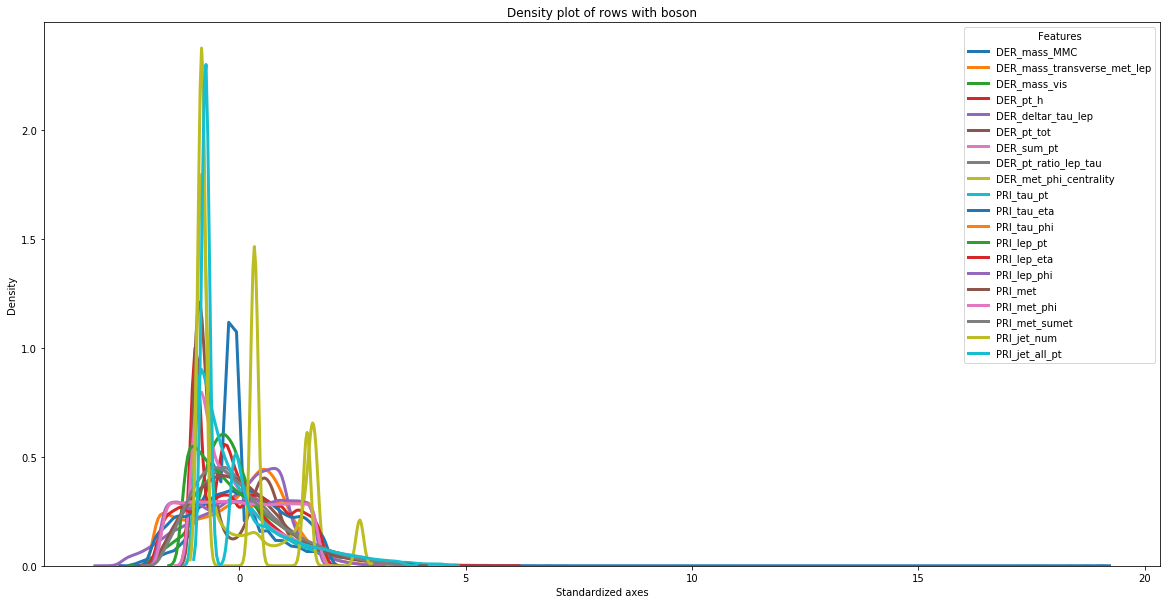

In [37]:
colors = {'b': 'rgb(31, 119, 180)', 
          's': 'rgb(255, 127, 14)'}
features = df_features_train_independent.iloc[:,1:].columns.values

fig=plt.figure(figsize=(20,10))
for feature in features:
    
    # Subset for boson and not boson
    subset_boson = df_features_train_independent[prediction_independent['Prediction'] == 'b']
    
    subset_non_boson = df_features_train_independent[prediction_independent['Prediction'] == 's']
    
    # Draw the density plot
    sns.distplot(standardize_personal(subset_boson[feature]), hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = feature)
#     print (feature)
#     print()
#     print ('non standardized distribution of values')
#     print (subset_boson[feature].describe(include=None))
    
# Plot formatting

plt.legend(prop={'size': 10}, title = 'Features')
plt.title('Density plot of rows with boson')
plt.xlabel('Standardized axes')
plt.ylabel('Density')

In [15]:
#inspect the distribution of each feature
subset_boson = df_features_train_independent[prediction_independent['Prediction'] == 'b']
colors = {'b': 'rgb(31, 119, 180)', 
          's': 'rgb(255, 127, 14)'}

fig=plt.figure(figsize=(20,10))
sns.distplot(standardize_personal(subset_boson['PRI_jet_num']), hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = feature)

plt.legend(prop={'size': 10}, title = 'Features')
plt.title('Density plot of rows with boson')
plt.xlabel('Standardized axes')
plt.ylabel('Density')

NameError: name 'feature' is not defined

<Figure size 1440x720 with 0 Axes>

Firstly each feature was standardized since the units were different. It can be seen that the distribution of certain features when they take the value of 'b'  are particularly interesting: PRI_jet_num, can take only three discrete values shows three spikes

Text(0,0.5,'Density')

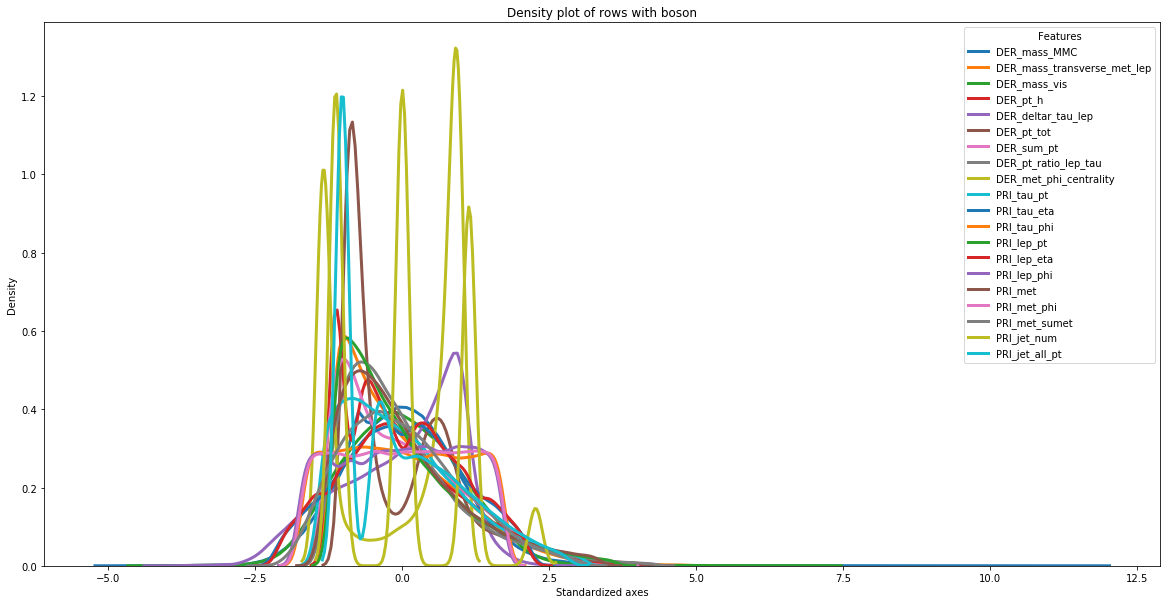

In [39]:
colors = {'b': 'rgb(31, 119, 180)', 
          's': 'rgb(255, 127, 14)'}
features = df_features_train_independent.iloc[:,1:].columns.values

fig=plt.figure(figsize=(20,10))
for feature in features:
    
    # Subset for boson and not boson
    subset_boson = df_features_train_independent[prediction_independent['Prediction'] == 'b']
    
    subset_non_boson = df_features_train_independent[prediction_independent['Prediction'] == 's']
    
    # Draw the density plot
    sns.distplot(standardize_personal(subset_non_boson[feature]), hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = feature)
#     print (feature)
#     print()
#     print ('non standardized distribution of values')
#     print (subset_non_boson[feature].describe(include=None))
    
# Plot formatting

plt.legend(prop={'size': 10}, title = 'Features')
plt.title('Density plot of rows with boson')
plt.xlabel('Standardized axes')
plt.ylabel('Density')

From the above plots, one can see that there are certain features whose variance is much bigger than otherswhen they take a value of 'b' or 's'. There are other features, however, such as DER_mass_MMC whose value distribution is extremely skewed when they take a value of 'b' or 's'. By comparing the different types of distribution of the features when having a value of 'b' or 's', one can see which ones are mostly difference to have an understanding of which features are most important in determining 'b' or 's'. ???????

Standardizing the arrays and discarting the indices

In [115]:
features = df_features_train_independent.iloc[:,1:].columns.values
df_features_train_independent_std=pd.DataFrame()

for feature in features:
    
    df_features_train_independent_std[feature]=standardize_personal(df_features_train_independent[feature])
df_features_train_independent_std.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_all_pt
0,0.715904,0.105135,0.778085,-0.370856,0.890626,1.667413,1.110794,0.351727,1.350620,-0.186942,0.846362,0.216463,0.687585,1.803575,-1.355489,-0.911778,-0.145534,0.995999,1.358011,1.138566
1,1.345006,0.652156,0.975702,0.134242,1.474933,-0.880886,-0.005831,-0.794577,1.365683,0.477191,1.688002,-1.650895,-0.416919,0.410801,0.030750,0.445188,-1.049897,-0.156359,0.219125,-0.027084
3,0.868090,1.056485,0.161119,-1.061302,1.242067,-0.987294,-0.762351,1.610541,-0.892973,-0.894636,-1.354092,0.012220,0.814872,-0.393267,-1.733304,-0.217817,0.040415,-1.116594,-0.919760,-0.828074
4,1.762979,-1.005338,2.129317,-0.660775,2.072097,0.035287,-1.038958,-0.505963,-0.976658,-0.500662,-1.800442,-1.221491,-0.953402,0.644240,0.838151,-1.598097,-0.473290,-1.519497,-0.919760,-0.828074
5,-0.648481,-1.112902,-0.635267,1.842399,-1.540890,2.926598,2.358347,-1.269078,0.583229,1.301477,0.314366,0.738354,-0.818906,-0.677795,0.996767,0.252010,1.241633,1.291053,2.496896,2.527606


Find the covariance matrix in order to the find its eigenvectors and eigenvalues which will be an indication of what are the most principal components since they will tell how much and in which direction the data mostly vary. This is in this case needed since the data have different units and meanings. It can happen, however that by standardizing the features some relationships will be lost. In fact, if on the one side to find the principal components standardization is needed to take account of the different orders of magnitude, it is also important to mention that this analysis is strongly subjected to variations of the features; for example, if a feature is multiplied by a constant, and then the principal components analysis is done, the results are going to be different from those done with the original features.

In [116]:
cov_df_features_train_independent_std=np.cov(df_features_train_independent_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_df_features_train_independent_std)

Perform the eigendecomposition on the covariance matrix Σ which is a d×d matrix where each element represents the covariance between two features

Singular value decomposition. The typical goal of a PCA is to reduce the dimensionality of the original feature space by projecting it onto a smaller subspace, where the eigenvectors will form the axes. However, the eigenvectors only define the directions of the new axis, since they have all the same unit length 1, which can confirmed by the following two lines of code:

In [117]:
#u,s,v=np.linalg.svd(df_features_train_independent_std[:20000].T)

In [118]:
for ev in eig_vecs:
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
print('Everything ok!')

Everything ok!


In order to decide which eigenvector(s) can dropped without losing too much information for the construction of lower-dimensional subspace, we need to inspect the corresponding eigenvalues: The eigenvectors with the lowest eigenvalues bear the least information about the distribution of the data; those are the ones can be dropped.
In order to do so, the common approach is to rank the eigenvalues from highest to lowest in order choose the top k
 eigenvectors.

In [119]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort()
eig_pairs.reverse()

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])

Eigenvalues in descending order:
5.189490246690572
2.575343303268405
2.22976147928584
1.596008572973852
1.3260364582524486
1.2489533956164773
0.9991554049508797
0.9899064341052262
0.8182961249311445
0.7510043782789503
0.6478097671538382
0.4041376933743798
0.36451479610794657
0.2563903150843971
0.22770160976914944
0.14154712272159525
0.10003972073470943
0.07874511245861111
0.05525238914480912
3.718776133860977e-11


In [120]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

trace1 = Bar(
        x=['PC %s' %i for i in range(1,20)],
        y=var_exp,
        showlegend=False)

trace2 = Scatter(
        x=['PC %s' %i for i in range(1,20)], 
        y=cum_var_exp,
        name='cumulative explained variance')

data = Data([trace1, trace2])

layout=Layout(
        yaxis=YAxis(title='Explained variance in percent'),
        title='Explained variance by different principal components')

fig = Figure(data=data, layout=layout)
py.iplot(fig)

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:39: DeprecationWarning:

plotly.graph_objs.Data is deprecated.
Please replace it with a list or tuple of instances of the following types
  - plotly.graph_objs.Scatter
  - plotly.graph_objs.Bar
  - plotly.graph_objs.Area
  - plotly.graph_objs.Histogram
  - etc.


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:558: DeprecationWarning:

plotly.graph_objs.YAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.YAxis
  - plotly.graph_objs.layout.scene.YAxis




Choose the top components

In [152]:
eig_pairs[0][1].reshape(20,1)
number_features=20
#decide how many principal components i get
number_pa=15
#define matrix to be filled in
matrix_w=np.ones((number_features, number_pa))
for i in range(number_pa):
    matrix_w[:,i] = eig_pairs[i][1]
matrix_w[:2]

array([[ 2.15622083e-02,  5.43093502e-01, -2.79042708e-02,
         5.60557631e-03, -1.05097371e-01, -1.98333757e-03,
        -2.13037252e-03, -5.84246338e-02, -3.16735457e-01,
        -3.30179925e-03, -8.88587517e-02,  4.50527796e-04,
        -2.10717699e-02, -2.97040736e-01,  6.80194655e-01],
       [-1.46365279e-01,  3.97152846e-02,  4.43968058e-01,
         8.80848008e-03, -4.43585494e-01,  2.51454415e-02,
         5.25249286e-03, -7.47805942e-02, -1.10757854e-02,
         1.48637071e-03,  1.38625091e-01,  1.09893696e-02,
        -6.27571332e-01,  1.40389350e-01, -9.59081935e-02]])

Transform the feature space

In [123]:
df_features_train_independent_std_transf = df_features_train_independent_std.dot(matrix_w)
df_features_train_independent_std_transf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1.947353,1.694135,0.285227,-1.908373,1.381452,-1.187362,-0.459060,-1.253993,0.561966,0.776575,0.724443,0.677564,-1.268328,-0.159888,0.044371
1,0.109193,1.836893,-0.910565,-1.478804,-0.333093,1.232057,-0.867428,0.310141,-1.839208,1.199960,-0.184820,-0.876671,-1.120901,0.392499,-0.355371
3,-2.830060,1.162408,1.786513,1.188352,0.448948,-1.225010,0.127402,0.523380,-0.545284,1.223647,0.193744,0.685737,0.027290,-0.051102,0.229403
4,-2.897410,2.522334,-1.866237,0.742227,1.145483,1.411496,-0.487003,-0.546213,-0.649707,0.278392,0.651619,1.724007,0.827502,-0.893250,0.153093
5,5.480477,-1.221138,-1.319864,0.325202,-0.310953,0.115465,0.894806,-1.690408,1.298901,-1.318480,0.954324,-0.723002,-0.023277,-1.413806,-0.329414


In [161]:
pca = PCA(n_components=15)
df_features_train_independent_std_transf_sickit=pca.fit_transform(df_features_train_independent_std)
df_features_train_independent_std_transf_sickit.shape

(212034, 15)

# Regression models

Outliers deletion for independent set and prediction set in order not to mix rows once the outliers are deleted

Setting the arrays for dependent and independent variables

In [124]:
# remove the indices from the dataframes and set up the dataframes for independent variable
yb_independent, input_data_independent, ids_independent=np.array(prediction_independent['Prediction']), np.array(df_features_train_independent.iloc[:,1:]), np.array(df_features_train_independent['Id'])

In [125]:
# remove the indices from the dataframes and set up the dataframes for dependent variable
yb_dependent, input_data_dependent, ids_dependent=np.array(prediction_dependent['Prediction']), np.array(df_features_train_dependent.iloc[:,1:]), np.array(df_features_train_dependent['Id'])

In [126]:
# remove the indices from the dataframes and set up the dataframes for primitive variable
yb_independent_pri, input_data_independent_pri, ids_dependent_pri=np.array(prediction_independent['Prediction']), np.array(df_features_train_independent_pri.iloc[:,1:]), np.array(df_features_train_independent['Id'])

In [127]:
# remove the indices from the dataframes and set up the dataframes for primitive variable
yb_independent_der, input_data_independent_der, ids_dependent_der=np.array(prediction_independent['Prediction']), np.array(df_features_train_independent_der.iloc[:,1:]), np.array(df_features_train_independent['Id'])

In [128]:
# remove the indices from the dataframes and set up the dataframes for independent variable
yb_independent_pa, input_data_independent_pa, ids_independent=np.array(prediction_independent['Prediction']), np.array(df_features_train_independent_std_transf), np.array(df_features_train_independent['Id'])

In [162]:
# remove the indices from the dataframes and set up the dataframes for independent variable
yb_independent_pa_scikit, input_data_independent_pa_scikit, ids_independent_scikit=np.array(prediction_independent['Prediction']), np.array(df_features_train_independent_std_transf_sickit), np.array(df_features_train_independent['Id'])

In [129]:
# remove the indices from the dataframes and set up the dataframes for independent variable
yb_toy, input_data_toy, ids_toy=np.array(df_toy['Prediction']), np.array(df_toy.iloc[:,2:]), np.array(df_toy['Id'])

In [163]:
# transform yb into numerical values
yb_independent[np.where(yb_independent=='b')] = 1.
yb_independent[np.where(yb_independent=='s')] = 0.
yb_independent=yb_independent.astype('float')

yb_independent_pri[np.where(yb_independent_pri=='b')] = -1.
yb_independent_pri[np.where(yb_independent_pri=='s')] = 1.
yb_independent_pri=yb_independent_pri.astype('float')

yb_independent_der[np.where(yb_independent_der=='b')] = -1.
yb_independent_der[np.where(yb_independent_der=='s')] = 1.
yb_independent_der=yb_independent_der.astype('float')

yb_dependent[np.where(yb_dependent=='b')] = -1.
yb_dependent[np.where(yb_dependent=='s')] = 1.
yb_dependent=yb_dependent.astype('float')

yb_independent_pa[np.where(yb_independent_pa=='b')] = 1.
yb_independent_pa[np.where(yb_independent_pa=='s')] = 0.
yb_independent_pa=yb_independent_pa.astype('float')


yb_toy[np.where(yb_toy=='b')] = 1.
yb_toy[np.where(yb_toy=='s')] = 0.
yb_toy=yb_toy.astype('float')


yb_independent_pa_scikit[np.where(yb_independent_pa_scikit=='b')] = 1.
yb_independent_pa_scikit[np.where(yb_independent_pa_scikit=='s')] = 0.
yb_independent_pa_scikit=yb_independent_pa_scikit.astype('float')


#Cut dataframe for fast testing
# lines_cut=200000
# tx=input_data[:lines_cut]
# y=yb[:lines_cut]
# y.shape


y_independent=yb_independent
y_dependent=yb_dependent
y_independent_pri=yb_independent_pri
y_independent_der=yb_independent_der
y_independent_pa=yb_independent_pa
y_toy=yb_toy
y_independent_pa_scikit=yb_independent_pa_scikit

tx_independent=input_data_independent
tx_dependent=input_data_dependent
tx_independent_pri=input_data_independent_pri
tx_independent_der=input_data_independent_der
tx_independent_pa=input_data_independent_pa
tx_toy=input_data_toy
tx_independent_pa_scikit=input_data_independent_pa_scikit
#input_data.shape

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:10: FutureWarning:

elementwise comparison failed; returning 

## Stochastic gradient descent 

In [ ]:
# Define the parameters of the algorithm.
max_iters = 30
gamma = 0.1
batch_size = 2000

# Initialization
w_initial = np.zeros(tx.shape[1])

# Start SGD.
start_time = datetime.datetime.now()
sgd_losses, sgd_ws = stochastic_gradient_descent(y, tx, w_initial, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

## Least Squares

In [17]:
w_independent=least_squares(y_independent,tx_independent)
loss_independent=compute_mse(y_independent, tx_independent, w_independent)
print('Weigths: ',w_independent,"\n\n",'RMSE: ',np.sqrt(2*loss_independent))

Weigths:  [ 2.04932129e-03 -9.87647137e-03 -5.80650004e-03 -5.57050222e-04
  1.66066638e-01 -2.74582847e-03 -1.42222499e+00 -5.61033090e-01
  9.11246889e-02  1.42184111e+00 -1.35554837e-03 -1.53170676e-03
  1.44253219e+00  7.49415475e-04  2.19418107e-04  1.13855879e-03
 -5.74301738e-05 -4.84529159e-04 -6.22725389e-02  1.42388253e+00] 

 RMSE:  0.8242047347570098


In [127]:
w_independent_pri=least_squares(y_independent_pri,tx_independent_pri)
loss_independent_pri=compute_mse(y_independent_pri, tx_independent_pri, w_independent_pri)
print('Weigths: ',w_independent_pri,"\n\n",'RMSE: ',np.sqrt(2*loss_independent_pri))

Weigths:  [-0.00231313 -0.00268096 -0.00772906  0.00139263  0.00090863 -0.00856707
  0.00283279  0.00110978 -0.177314    0.00546889] 

 RMSE:  0.9122897073769244


In [128]:
w_independent_der=least_squares(y_independent_der,tx_independent_der)
loss_independent_der=compute_mse(y_independent_der, tx_independent_der, w_independent_der)
print('Weigths: ',w_independent_der,"\n\n",'RMSE: ',np.sqrt(2*loss_independent_der))

Weigths:  [-8.56431915e-03  9.11847475e-04 -1.21194634e-05  1.09103174e-01
 -3.80511690e-03  1.57573761e-03 -2.57832485e-01  8.59247565e-02] 

 RMSE:  0.8362679158334438


In [156]:
w_dependent=least_squares(y_dependent,tx_dependent)
loss_dependent=compute_mse(y_dependent, tx_dependent, w_dependent)
print('Weigths: ',w_dependent,"\n\n",'RMSE: ',np.sqrt(2*loss_dependent))

Weigths:  [-2.62553709e-03  7.53728577e-04  3.81635024e-03  4.42530934e-01
  3.31633862e-04  2.66332632e-03  5.01149377e-04  2.49135001e-04
  1.85232732e-03 -3.81656559e-03 -2.65004507e-01] 

 RMSE:  0.9197140413917396


In [154]:
w_independent_pa=least_squares(y_independent_pa,tx_independent_pa)
loss_independent_pa=compute_mse(y_independent_pa, tx_independent_pa, w_independent_pa)
print('Weigths: ',w_independent_pa,"\n\n",'RMSE: ',np.sqrt(2*loss_independent_pa))

Weigths:  [-0.04892994 -0.04613699  0.10681167 -0.00192242 -0.04292553  0.0017298
 -0.0031567  -0.03173068  0.0146505  -0.00093182  0.06380306 -0.00045956
 -0.07331662 -0.0148058   0.02700359] 

 RMSE:  0.7816315853206088


In [164]:
w_independent_scikit=least_squares(y_independent_pa_scikit,tx_independent_pa_scikit)
loss_independent_scikit=compute_mse(y_independent_pa_scikit, tx_independent_pa_scikit, w_independent_scikit)
print('Weigths: ',w_independent_scikit,"\n\n",'RMSE: ',np.sqrt(2*loss_independent_scikit))

Weigths:  [-0.04892994 -0.04613699  0.10681167 -0.00192242  0.04292553 -0.0017298
  0.0031567   0.03173068 -0.0146505  -0.00093182  0.06380306 -0.00045956
 -0.07331662  0.0148058   0.02700359] 

 RMSE:  0.7816315853206195


In [58]:
w_toy=least_squares(y_toy,tx_toy)
loss_toy=compute_mse(y_toy, tx_toy, w_toy)
print('Weigths: ',w_toy,"\n\n",'RMSE: ',np.sqrt(2*loss_toy))

Weigths:  [-1.18117509e-05  3.73037085e-03  2.31474490e-03 -2.53409168e-04
  5.65402240e-02 -3.22250471e-04  2.03698936e-02 -1.16949996e-01
  8.27662434e-04  1.14756576e+00  1.34416135e-01 -6.02801295e-02
 -8.31877094e-02 -1.15025104e+00  1.73813330e-03 -1.77292327e-03
 -1.15387757e+00  1.80337119e-03 -3.62477724e-03 -1.10758752e-03
 -2.85066337e-03  3.43058874e-04  2.45663181e-01  3.79272279e-03
 -1.33407594e-02 -1.59366117e-02  5.87996528e-03 -1.50465416e-03
  1.71266020e-03 -1.15079580e+00] 

 RMSE:  0.4190150462656002


### Least square polynomial expansion

In [50]:
def polynomial_features(x, order):
    "https://stackoverflow.com/questions/11723779/2d-numpy-power-for-polynomial-expansion"
    """For each row of ndarray x, the polynomial expansions are computed, i.e
    for row [x1, x2] and order 2, the following row of the result matrix is
    computed: [1, x1, x1**2, x2, x1*x2, x1**2*x2, x2**2, x1*x2**2, x1**2*x2**2]"""
    x = np.asarray(x).T[np.newaxis]
    n = x.shape[1]
    power_matrix = np.tile(np.arange(order + 1), (n, 1)).T[..., np.newaxis]
    X = np.power(x, power_matrix)
    I = np.indices((order + 1, ) * n).reshape((n, (order + 1) ** n)).T
    F = np.product(np.diagonal(X[I], 0, 1, 2), axis=2)
    return F.T

aa=np.array([[1,2,3,4,7,5],[5,9,13,7,8,7]])
gg=np.array([2,3])

tx_independent_exp=polynomial_features(aa, 2)
w_independent_exp=least_squares(gg,tx_independent_exp)
loss_independent_exp=compute_mse(gg, tx_independent_exp, w_independent_exp)
print('Weigths: ',w_independent_exp,"\n\n",'RMSE: ',np.sqrt(2*loss_independent_exp))

Weigths:  [ 5.04127420e-10  3.18011195e+02 -6.28057022e+03  1.79713729e-10
  2.14712206e+03  4.09638105e+01  1.00000000e+00  3.67014756e-01
  9.01101978e-01 -3.18011195e+02  5.57892294e+03  3.57931729e+02
 -2.14712206e+03  1.50947418e+03 -5.78617847e+02 -3.67014756e-01
  1.09889802e+00 -2.57405510e-11  7.01647279e+02 -3.57931729e+02
 -4.78296334e-11 -1.55043799e+03  5.78617847e+02 -1.41056587e-11
 -2.00000000e+00  2.74839628e-11  2.45732111e-12  3.96455362e-11
  4.05682448e+02  5.10697033e+02  1.36071634e-10 -1.70003843e+02
  9.98112257e+00  7.03166249e-11 -7.69414698e+00 -6.23650104e+00
 -4.05682448e+02 -5.52598640e+01 -2.97323410e+01  1.70003843e+02
 -5.86666667e+01  2.58818911e+02  7.69414698e+00  6.23650104e+00
  3.80797806e-13 -4.55437169e+02  2.97323410e+01 -8.58264716e-12
  4.86855441e+01 -2.58818911e+02 -1.27591946e-12 -8.62908661e-12
 -8.44408542e-13 -1.25923419e-12 -8.24886781e-11 -1.48192607e+02
 -1.09611111e+02 -1.69773956e-11  8.31695835e+00  2.26492876e+00
  3.89069385e-1

## Cross Validation

### Ridge regression

-0.003525258229526353
0.7816776395755742


[-0.0035308477843541113,
 -0.003530547020901538,
 -0.00352942651079723,
 -0.003525258229526353,
 -0.0035098387857007596,
 -0.0034539882404683764,
 -0.0032671862365982055,
 -0.002791435713190897,
 -0.00212567921830233,
 -0.0015117469836318793,
 -0.0008158671849213232,
 -0.000299881720459309,
 -8.91488527604322e-05,
 -2.4625509513012783e-05,
 -6.65917341417257e-06]

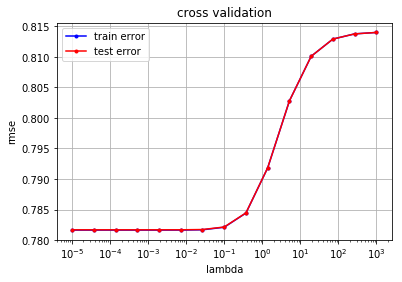

In [132]:
# Define the parameters of the algorithm.
seed = 1
k_fold = 8
lambdas = np.logspace(-5, 3, 15)

# Initialization
k_indices=build_k_indices(yb_independent_pa, k_fold, seed)
cross_rmse_train=[]
cross_rmse_test=[]
wsi_train_avg=[]
for lambda_ in lambdas:
    rmse_tr = []
    rmse_te = []
    wsi_train_lst=[]
    for k in range(k_fold):
        loss_tr, loss_te,wsi_train=cross_validation_ridge(y_independent_pa, tx_independent_pa, k_indices, k, lambda_)
        rmse_tr.append(loss_tr)
        rmse_te.append(loss_te)
        wsi_train_lst.append(wsi_train)
    cross_rmse_train.append(np.mean(rmse_tr))
    cross_rmse_test.append(np.mean(rmse_te))
    wsi_train_avg.append(np.mean(wsi_train))
cross_validation_visualization(lambdas, cross_rmse_train, cross_rmse_test)    
print(wsi_train_avg[np.argmin(cross_rmse_test)])
print(np.min(cross_rmse_test))
wsi_train_avg

In [139]:
# select the lambda that perform better and use it to do the regression
lambda_final_index=np.where(wsi_train_avg==wsi_train_avg[np.argmin(cross_rmse_test)])[0][0]
loss_tr, loss_te,wsi_ridge=cross_validation_ridge(y_independent_pa, tx_independent_pa, k_indices, k, lambdas[lambda_final_index])

### Least squares

Cross validation for both the dependent and the independent set and merging of weights

In [165]:
# Define the parameters of the algorithm.
seed = 1
k_fold = 8

# Initialization
k_indices=build_k_indices(y_independent_pa, k_fold, seed)

cross_rmse_train=[]
cross_rmse_test=[]
wsi_train_lst=[]

for k in range(k_fold):
    loss_tr, loss_te,wsi_train=cross_validation_least_squares(y_independent_pa, tx_independent_pa, k_indices, k)
    cross_rmse_train.append(loss_tr)
    cross_rmse_test.append(loss_te)
    wsi_train_lst.append(wsi_train)
cross_rmse_train=np.average(cross_rmse_train)
cross_rmse_test=np.average(cross_rmse_test)
wsi_train_lst=np.average(wsi_train_lst,axis=0)
w_independent=wsi_train_lst
print(wsi_train_lst)
print(cross_rmse_test)

[-0.04893076 -0.04614413  0.10681152 -0.00191643 -0.04291894  0.00173558
 -0.0031575  -0.03173817  0.01464794 -0.0009359   0.06381043 -0.00046158
 -0.07331711 -0.01480542  0.02699981]
0.7816777064221604


In [160]:
# Define the parameters of the algorithm.
seed = 1
k_fold = 8

# Initialization
k_indices=build_k_indices(y_dependent, k_fold, seed)

cross_rmse_train=[]
cross_rmse_test=[]
wsi_train_lst=[]

for k in range(k_fold):
    loss_tr, loss_te,wsi_train=cross_validation_least_squares(y_dependent, tx_dependent, k_indices, k)
    cross_rmse_train.append(loss_tr)
    cross_rmse_test.append(loss_te)
    wsi_train_lst.append(wsi_train)
cross_rmse_train=np.average(cross_rmse_train)
cross_rmse_test=np.average(cross_rmse_test)
wsi_train_lst=np.average(wsi_train_lst,axis=0)
w_dependent=wsi_train_lst
print(wsi_train_lst)
print(cross_rmse_test)

[-2.65998786e-03  7.53517630e-04  3.78821449e-03  4.42666406e-01
  3.32166843e-04  2.68653192e-03  4.91414549e-04  2.50826589e-04
  1.86958172e-03 -3.82554566e-03 -2.65037854e-01]
0.9198566807625578


In [161]:
# combining the weights given by the two set of dataframes
w=pd.Series(np.ones((df_test.shape[1]-2)))
total_features=pd.Series(df_train.iloc[:,2:].columns.values)
independent_features=pd.Series(df_features_train_independent.iloc[:,1:].columns.values)
dependent_features=pd.Series(df_features_train_dependent.iloc[:,1:].columns.values)

w[total_features.index[total_features.isin(independent_features)]]=w_independent
w[total_features.index[total_features.isin(dependent_features)]]=w_dependent
w

0     0.000177
1    -0.009769
2    -0.003744
3    -0.001792
4    -0.002660
5     0.000754
6     0.003788
7     0.144804
8    -0.002774
9    -1.743511
10   -0.508661
11    0.101074
12    0.442666
13    1.745193
14   -0.001123
15   -0.001455
16    1.762601
17    0.000555
18    0.000221
19    0.004159
20    0.000029
21   -0.000576
22    0.000332
23    0.002687
24    0.000491
25    0.000251
26    0.001870
27   -0.003826
28   -0.265038
29    1.745156
dtype: float64

## Logistic Regression


In [40]:
from helpers import sample_data, load_data, standardize

# load data.
height, weight, gender = load_data()

# build sampled x and y.
seed = 1
y = np.expand_dims(gender, axis=1)
X = np.c_[height.reshape(-1), weight.reshape(-1)]
y, X = sample_data(y, X, seed, size_samples=200)
x, mean_x, std_x = standardize(X)

In [57]:
max_iter = 100
gamma = 0.01
lambda_ = 0.01
threshold = 1e-8
points=10000
tx_log=tx_toy
losses = []
y=y_toy[:, np.newaxis]
y_log=y
w = np.zeros((tx_log[:points].shape[1], 1))
loss=1

# start the logistic regression
for iter in range(max_iter):
    if loss<0:
        break
    
    # get loss and update w.
    loss, w = learning_by_penalized_gradient(y_log[:points], tx_log[:points], w, gamma, lambda_)
    # log info


    if iter % 10 == 0:
        print("Current iteration={i}, loss={l}".format(i=iter, l=loss))
    # converge criterion
    losses.append(loss)

    
    if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
         break
    
# # visualization
# visualization(y, x, mean_x, std_x, w, "classification_by_logistic_regression_penalized_gradient_descent")
print("loss={l}".format(l=calculate_loss(y_log[:points], tx_log[:points], w)))
#print('w',w)

Current iteration=0, loss=6931.471805599453


/Users/gianlucamancini/Desktop/EPFL EDU/machine_learning/ml_project1/implementations.py:200: RuntimeWarning:

invalid value encountered in true_divide



Current iteration=10, loss=nan


KeyboardInterrupt: 

## Test

Firstly the test data have to be formatted, cleaned and features have to be generated in the same manner the train set was treated

In [140]:
df_test_1=df_test[['Id','DER_mass_MMC','DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltar_tau_lep', 
                              'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'PRI_tau_pt', 
                              'PRI_tau_eta', 'PRI_tau_phi', 'PRI_lep_pt', 'PRI_lep_eta','PRI_lep_phi', 'PRI_met', 'PRI_met_phi', 
                               'PRI_met_sumet','PRI_jet_num', 'PRI_jet_all_pt' ]]
# defining the dependent features
df_test_1['PRI_jet_num']=df_test_1['PRI_jet_num'].astype('float')


/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [141]:
for column_name in df_test_1.columns.values:
    
    index_to_change=df_test_1.index[np.abs(df_test_1[column_name]-df_test_1[column_name].mean()) >= (3*df_test_1[column_name].std())]
    df_test_1[column_name][index_to_change]=np.median(df_test_1[column_name])
    
for column_name in df_test_1.columns.values:
    
    df_test_1[column_name][df_test_1[column_name]==-999.0]=np.median(df_test_1[column_name])

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:982: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/pandas/core/serie

In [142]:
features = df_test_1.iloc[:,1:].columns.values
df_test_1_std=pd.DataFrame()

for feature in features:
    
    df_test_1_std[feature]=standardize_personal(df_test_1[feature])

In [143]:
cov_df_test_1_std=np.cov(df_test_1_std.T)
eig_vals_test, eig_vecs_test = np.linalg.eig(cov_df_test_1_std)

In [144]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs_test = [(np.abs(eig_vals_test[i]), eig_vecs_test[:,i]) for i in range(len(eig_vals_test))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs_test.sort()
eig_pairs_test.reverse()

In [153]:
eig_pairs_test[0][1].reshape(20,1)
number_features=20
#decide how many principal components i get
number_pa=15
#define matrix to be filled in
matrix_w_test=np.ones((number_features, number_pa))

for i in range(number_pa):
    matrix_w_test[:,i] = eig_pairs_test[i][1]

df_test_1_std_transf = df_test_1_std.dot(matrix_w_test)
df_test_1_std_transf.head()
matrix_w_test[:2]

array([[ 0.0264965 , -0.48276725,  0.23117773,  0.00426952, -0.04097468,
        -0.00073196, -0.00270436,  0.08347552, -0.3980339 , -0.0030221 ,
         0.04680802,  0.01093068, -0.58153301, -0.40459387, -0.05506584],
       [-0.13482053, -0.23546424, -0.3768316 ,  0.00127697, -0.47571351,
         0.05866973,  0.00727656,  0.1180071 , -0.01764987,  0.00567363,
        -0.12282751,  0.00514613, -0.32915086,  0.56042111,  0.20834641]])

In [166]:
df_test_1_std_transf=df_test_1_std.dot(matrix_w)
df_test_1_std_transf.head()
matrix_w[:2]

array([[ 2.15622083e-02,  5.43093502e-01, -2.79042708e-02,
         5.60557631e-03, -1.05097371e-01, -1.98333757e-03,
        -2.13037252e-03, -5.84246338e-02, -3.16735457e-01,
        -3.30179925e-03, -8.88587517e-02,  4.50527796e-04,
        -2.10717699e-02, -2.97040736e-01,  6.80194655e-01],
       [-1.46365279e-01,  3.97152846e-02,  4.43968058e-01,
         8.80848008e-03, -4.43585494e-01,  2.51454415e-02,
         5.25249286e-03, -7.47805942e-02, -1.10757854e-02,
         1.48637071e-03,  1.38625091e-01,  1.09893696e-02,
        -6.27571332e-01,  1.40389350e-01, -9.59081935e-02]])

In [167]:
#tx_test=df_test.iloc[:,2:]
tx_test=df_test_1_std_transf
y_pred=predict_labels(wsi_train_lst,np.array(tx_test))
create_csv_submission(df_test['Id'], y_pred, 'trial_least_square_pa_train')

## Overfitting or underfitting

# Other stuff
Build Polynomial